In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
df = pd.read_csv('../data/tweets.csv')

In [32]:
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [33]:
df[["airline_sentiment", "text"]].head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [34]:
df[["airline_sentiment", "text"]].isna().sum()

airline_sentiment    0
text                 0
dtype: int64

## EDA

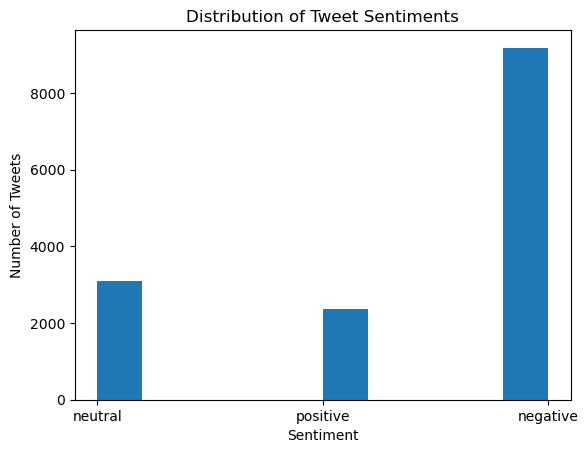

In [35]:
plt.hist(df['airline_sentiment'])
plt.title('Distribution of Tweet Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.show()

Les classes sont un peu déséquilibrée. Comme on a beaucoup de données on peut se dire que on pourrait faire de l'undersampling. Mais possiblement on peut aussi jouer sur les weights ou faire de l'undersampling.

In [36]:
def remove_mentions(text):
    return ' '.join(word for word in text.split() if not word.startswith('@'))

def remove_hashtags(text):
    return ' '.join(word for word in text.split() if not word.startswith('#'))

In [37]:
df["cleaned_text"] = df["text"].apply(remove_mentions).apply(remove_hashtags).str.lower()

In [38]:
df[["airline_sentiment", "cleaned_text", "text"]].head()

,airline_sentiment,cleaned_text,text
0,neutral,what said.,@VirginAmerica What @dhepburn said.
1,positive,plus you've added commercials to the experienc...,@VirginAmerica plus you've added commercials t...
2,neutral,i didn't today... must mean i need to take ano...,@VirginAmerica I didn't today... Must mean I n...
3,negative,"it's really aggressive to blast obnoxious ""ent...",@VirginAmerica it's really aggressive to blast...
4,negative,and it's a really big bad thing about it,@VirginAmerica and it's a really big bad thing...


# Préparation des données pour le modèle

In [39]:
from sklearn.model_selection import train_test_split

In [40]:
# df['airline_sentiment'] = df['airline_sentiment'].replace('neutral', np.nan)
# df = df.dropna(subset=['airline_sentiment'])

In [41]:
X, y = df["cleaned_text"], df["airline_sentiment"]

In [42]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1, stratify=y_temp, random_state=42)

Maintenant que nous avons divisé notre jeu de données et train, val, test nous pouvont maintenant commencer à implémenter la méthode utilisant les Transformeurs (comme BERT ou RoBERTa).

In [43]:
from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
# tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
# Test on a simple sentence
# text = 'ChatGPT is a language model developed by OpenAI, based on the GPT (Generative Pre-trained Transformer) architecture.'

# # Tokenize and encode the text
# encoding = tokenizer.encode(text)
# print("Token IDs:", encoding)

# # Convert token IDs back to tokens
# tokens = tokenizer.convert_ids_to_tokens(encoding)
# print("Tokens:", tokens)

In [44]:
X_train = tokenizer(X_train.to_list(), 
                    padding = True,
                    truncation = True,
                    max_length = 512,
                    return_tensors = 'pt')
X_val = tokenizer(X_val.to_list(), 
                    padding = True,
                    truncation = True,
                    max_length = 512,
                    return_tensors = 'pt')
X_test = tokenizer(X_test.to_list(), 
                    padding = True,
                    truncation = True,
                    max_length = 512,
                    return_tensors = 'pt')

Encodage des labels

In [45]:
from sklearn.preprocessing import LabelEncoder
import torch

In [46]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)

## Classification

In [52]:
import torch
from torch.optim import AdamW
from datasets import Dataset
from transformers import DistilBertForSequenceClassification, TrainingArguments, Trainer

Dans un premier temps créons un dataset pytorch

In [53]:
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=3
).to("cpu")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [54]:
optimizer = AdamW(model.parameters(), lr=5e-5)

In [55]:
train_dataset = Dataset.from_dict({
    "input_ids": X_train["input_ids"].tolist(),
    "attention_mask": X_train["attention_mask"].tolist(),
    "labels": y_train_enc.tolist()
})

val_dataset = Dataset.from_dict({
    "input_ids": X_val["input_ids"].tolist(),
    "attention_mask": X_val["attention_mask"].tolist(),
    "labels": y_val_enc.tolist()
})

test_dataset = Dataset.from_dict({
    "input_ids": X_test["input_ids"].tolist(),
    "attention_mask": X_test["attention_mask"].tolist(),
    "labels": y_test_enc.tolist()
})

On va utiliser TrainingArguments de transformers pour simplifier le code:

In [56]:
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    seed=42
)


Pour l'évaluation:

In [59]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    labels = p.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="macro")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}



Peut être que l'utilisation de micro au lieu de weighted n'est pas une super idée au vu du déséquilibre de classe...

Utilisation de Trainer:

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Fine-tune the model
trainer.train()

#Evaluate the model
trainer.evaluate()

c:\Users\clemm\miniconda3\envs\sentiment-env\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.278900,0.547998,0.830046,0.796396,0.761506,0.774423


c:\Users\clemm\miniconda3\envs\sentiment-env\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
